In [1]:
import sys
sys.path.append("../../../../")

In [2]:
import sys
sys.path.append("../../../../")
import torch
from torch import nn
from torch.optim import AdamW

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pricer.evaluate import evaluate
from pricer.items import Item
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm.notebook import tqdm

In [4]:
LITE_MODE = False
username = "ed-donner"
dataset = f"{username}/items_lite" if LITE_MODE else f"{username}/items_full"
train, val, test = Item.get_from_hub(dataset)
print(f"Loaded {len(train):,} training items, {len(val):,} validation items, {len(test):,} test items")

Loaded 800,000 training items, 10,000 validation items, 10,000 test items


In [5]:
def get_dataframe(train,val,test):
    train_df = [{"text": item.summary, "price": float(item.price)} for item in tqdm(train)]
    val_df = [{"text": item.summary , "price": float(item.price)} for item in tqdm(val)]
    test_df = [{"text": item.summary , "price": float(item.price)} for item in tqdm(test)]
    return pd.DataFrame(train_df),pd.DataFrame(val_df),pd.DataFrame(test_df)

In [6]:
train_df ,val_df,test_df  = get_dataframe(train ,val ,test)

  0%|          | 0/800000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [7]:
class NN(nn.Module):
    def __init__(self, input_size= 2000):
        super(NN, self).__init__()
        self.layer1 = nn.Linear(input_size, 512)
        self.layer2 = nn.Linear(512, 512)
        self.layer3 = nn.Linear(512, 512)
        self.layer4 = nn.Linear(512, 256)
        self.layer5 = nn.Linear(256, 256)
        self.layer6 = nn.Linear(256, 256)
        self.layer7 = nn.Linear(256, 256)
        self.layer8 = nn.Linear(256, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        output1 = self.relu(self.layer1(x))
        output2 = self.relu(self.layer2(output1))
        output3 = self.relu(self.layer3(output2))
        output4 = self.relu(self.layer4(output3))
        output5 = self.relu(self.layer5(output4))
        output6 = self.relu(self.layer6(output5))
        output7 = self.relu(self.layer7(output6))
        output8 = self.layer8(output7)
        return output8

In [8]:
model = NN()

In [10]:
vectorizer = TfidfVectorizer(
                    max_features=2000,
                    stop_words="english",
                    ngram_range=(1, 2),
                    sublinear_tf=True
                )
X_train = vectorizer.fit_transform(train_df["text"])
X_val = vectorizer.transform(val_df["text"])
X_test = vectorizer.transform(train_df["text"])           


In [11]:
X_train.shape

(800000, 2000)

In [12]:
from torch.utils.data import TensorDataset, DataLoader

In [13]:
X_train_dense = torch.tensor(
    X_train.toarray(),
    dtype=torch.float32
)

y_train = torch.tensor(
    train_df["price"].values,
    dtype=torch.float32
).unsqueeze(1)
X_val_dense = torch.tensor(
    X_val.toarray(),
    dtype=torch.float32
)

y_val = torch.tensor(
    val_df["price"].values,
    dtype=torch.float32
).unsqueeze(1)

train_dataset = TensorDataset(X_train_dense, y_train)
val_dataset = TensorDataset(X_val_dense, y_val)


In [14]:
train_loader = DataLoader(train_dataset, batch_size = 256 , shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 256, )

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()

In [16]:
EPOCHS = 100
EVAL_EPOCHS = 1  # evaluate every epoch
PATIENCE = 5     # early stopping patience

train_losses = []
val_losses = []
val_epochs = []

best_val = float('inf')
counter = 0

# Learning rate scheduler (without verbose)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

for epoch in range(EPOCHS):
    # -------- TRAIN --------
    model.train()
    train_loss = 0.0

    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1} [train]"):
        optimizer.zero_grad()
        preds = model(X)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # -------- VALIDATE --------
    if (epoch + 1) % EVAL_EPOCHS == 0:
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for X, y in tqdm(val_loader, desc=f"Epoch {epoch+1} [val]"):
                preds = model(X)
                loss = criterion(preds, y)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_epochs.append(epoch + 1)

        print(f"Epoch [{epoch+1}/{EPOCHS}] Train MSE: {train_loss:.4f} Val MSE: {val_loss:.4f}")

        # ---- early stopping & checkpointing ----
        if val_loss < best_val:
            best_val = val_loss
            counter = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            counter += 1
            if counter >= PATIENCE:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        # ---- step the scheduler ----
        scheduler.step(val_loss)

# After training, load best model
model.load_state_dict(torch.load("best_model.pt"))

Epoch 1 [train]:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 1 [val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [1/100] Train MSE: 16129.7991 Val MSE: 13536.2229


Epoch 2 [train]:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 2 [val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [2/100] Train MSE: 12883.1441 Val MSE: 11979.8476


Epoch 3 [train]:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 3 [val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [3/100] Train MSE: 10590.6170 Val MSE: 10885.9614


Epoch 4 [train]:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 4 [val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [4/100] Train MSE: 8638.6721 Val MSE: 10624.8310


Epoch 5 [train]:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 5 [val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [5/100] Train MSE: 6940.8082 Val MSE: 10611.9112


Epoch 6 [train]:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 6 [val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [6/100] Train MSE: 5554.1911 Val MSE: 10691.6256


Epoch 7 [train]:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 7 [val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [7/100] Train MSE: 4592.1484 Val MSE: 10944.6034


Epoch 8 [train]:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 8 [val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [8/100] Train MSE: 3912.8811 Val MSE: 10827.7666


Epoch 9 [train]:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 9 [val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [9/100] Train MSE: 3431.8068 Val MSE: 11047.6658


Epoch 10 [train]:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 10 [val]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch [10/100] Train MSE: 2600.9360 Val MSE: 10875.3613
Early stopping triggered at epoch 10


<All keys matched successfully>

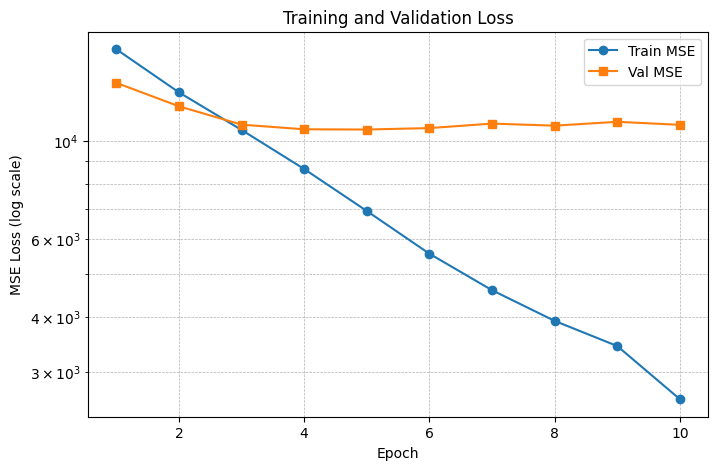

In [17]:
plt.figure(figsize=(8,5))

plt.plot(range(1, len(train_losses)+1), train_losses, label='Train MSE', marker='o')
plt.plot(val_epochs, val_losses, label='Val MSE', marker='s')

plt.yscale('log')  # logarithmic scale
plt.xlabel('Epoch')
plt.ylabel('MSE Loss (log scale)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()


In [18]:
vectorizer.transform([test[0].summary]).toarray().shape

(1, 2000)

In [19]:
model(torch.tensor(vectorizer.transform([test[0].summary]).toarray(), dtype = torch.float32)).detach().item()

191.1040496826172

In [20]:
model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

In [21]:
def predict_MLP(item):
    model.eval()
    with torch.no_grad():
        output = model(torch.tensor(vectorizer.transform([item.summary]).toarray(), dtype = torch.float32)).detach().item()
    return output

In [22]:
evaluate(predict_MLP, test)

  0%|          | 0/200 [00:00<?, ?it/s]

$28 $82 $27 $26 $16 $31 $62 $7 $21 $9 $193 $181 $76 $92 $3 $8 $108 $1 $41 $182 $67 $81 $16 $29 $140 $115 $176 $7 $21 $49 $42 $18 $70 $5 $10 $306 $45 $2 $126 $23 $124 $24 $46 $126 $146 $19 $23 $25 $32 $41 $4 $93 $61 $39 $6 $23 $19 $142 $50 $25 $108 $32 $13 $68 $242 $33 $42 $63 $35 $144 $8 $21 $56 $72 $10 $27 $55 $13 $14 $38 $61 $27 $54 $54 $35 $87 $177 $22 $14 $46 $22 $142 $6 $2 $25 $10 $5 $44 $78 $258 $48 $12 $1 $78 $12 $94 $35 $306 $14 $5 $32 $6 $63 $16 $116 $26 $37 $37 $8 $248 $36 $69 $35 $51 $117 $40 $8 $19 $40 $23 $37 $51 $128 $4 $83 $58 $131 $3 $35 $3 $17 $168 $6 $51 $25 $24 $4 $164 $68 $25 $9 $108 $6 $21 $28 $93 $53 $9 $4 $5 $103 $3 $7 $10 $257 $15 $258 $28 $9 $20 $41 $4 $285 $35 $43 $57 $11 $9 $17 $0 $117 $36 $176 $22 $51 $16 $9 $11 $9 $1 $52 $23 $6 $98 $17 $4 $27 $12 $13 $23 

## We have obtained far most the best off price and its 54$ with just a simple MLP.